In [1]:
import numpy as np
import fenics
import scipy.sparse as sps
import scipy.sparse.linalg as spla
import scipy.io as sio
# from fenics_to_scipy_sparse_csr_conversion import convert_fenics_csr_matrix_to_scipy_csr_matrix, vec2fct
from fenics_interactive_impulse_response_plot import fenics_interactive_impulse_response_plot
import matplotlib.pyplot as plt
from fenics_function_smoother import FenicsFunctionSmoother
from fenics_function_fast_grid_evaluator import FenicsFunctionFastGridEvaluator
from mesh_makers import circle_mesh
from random_fenics_function_makers import random_smooth_partition_of_unity, FenicsSmoothFunctionMaker, randn_fenics_function
from plot_ellipse import plot_ellipse
from interpolate_matrices import interpolate_matrices
from make_fenics_amg_solver import make_fenics_amg_solver
from poisson_interpolation import PoissonSquaredInterpolation
from localpsf_helpers import *
from localpsf import *
import hlibpro_wrapper as hpro
from basic_randomized_svd import basic_randomized_svd
from load_angel_peak_badlands_image_into_fenics import load_angel_peak_badlands_image_into_fenics

In [2]:
fine_mesh_h=5e-3
mesh_h= 2e-2 # 1e-2
finite_element_order=1
# final_time_T=5e-4
final_time_T = 1e-2 # 1e-2
num_timesteps=35
noise_level=5e-3
mesh_center = np.array([0.5,0.5])
mesh_radius = 0.5
num_random_matrices_for_conductivity_field= 4
conductivity_interpolation_temperature= 5 #3
boundary_tol = 0.5
num_std_dev_tau=3
a_reg = 1e-4 # Morozov: 4.4 % noise
# a_reg = 5e-5 # Morozov: 2.9 % noise <-- good
# a_reg = 2e-5 # Morozov: 1.7 % noise
# a_reg = 1e-5 # Morozov: 1.2 % noise
# a_reg = 1e-6 # Morozov: 0.58 % noise, too small for mesh?

In [3]:
np.random.seed(1)

In [4]:
fine_mesh = circle_mesh(mesh_center, mesh_radius, 1./fine_mesh_h)
fine_V = fenics.FunctionSpace(fine_mesh, 'CG', finite_element_order)

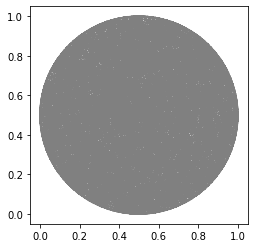

In [5]:
mesh = circle_mesh(mesh_center, mesh_radius, 1./mesh_h)
V = fenics.FunctionSpace(mesh, 'CG', finite_element_order)
fenics.plot(mesh)

X = V.tabulate_dof_coordinates()
N = V.dim()
d = mesh.geometric_dimension()

Make conductivity field $\kappa$ defined by
$$\kappa_{ij}(x) := \sum_{k=1}^4 w_k(x)\left(C_k\right)_{ij}$$
where $C_k$ are randomish matrices and $w_k$ are randomish smooth fields.

We build the functions $w_k$ on a very fine grid that always stays the same for reproducibility, then interpolate them to different coarser grid for different runs/numerical experiments.

Text(0.5, 1.0, 'f_4672')

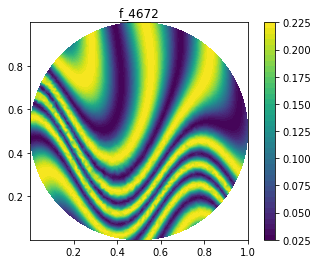

In [33]:
dl = fenics

def wiggly_function(V0):
    n=150
    mesh = dl.RectangleMesh(dl.Point(-1.,-1.), dl.Point(2., 2.), n,n)
    V = dl.FunctionSpace(mesh, 'CG', 2)
    u = dl.interpolate(dl.Expression('0.5 + 2.*sin(30*x[0])',domain=mesh, degree=5), V)
    old_coords = mesh.coordinates()

    xx0 = old_coords[:,0]
    yy0 = old_coords[:,1]

    xx1 = xx0
    yy1 = yy0 + 0.2 * np.cos(5*xx0)

    xx2 = yy1 + 0.3 * xx1
    yy2 = xx1 + 0.3 * np.sin(5*(yy1-0.35))

    xx3 = (xx2 + yy2)
    yy3 = (xx2 - yy2) + 0.2 * np.cos(8*(xx2 + yy2))

    new_coords = np.array([xx3, yy3]).T

    mesh.coordinates()[:] = new_coords

    u0 = dl.interpolate(u, V0)
    return u0

kp = wiggly_function(V)

cm = dl.plot(kp)
plt.colorbar(cm)
plt.title(kp)

In [34]:
fine_ww = random_smooth_partition_of_unity(num_random_matrices_for_conductivity_field, fine_V, 
                                           temperature=conductivity_interpolation_temperature, normalize=True)

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


In [59]:
for fw in fine_ww:
    fw.set_allow_extrapolation(True)
    
ww = [fenics.interpolate(fw, V) for fw in fine_ww]

In [60]:
C0 = np.array([[0.50,  0.25],
               [0.25,  0.25]])/50
C1 = np.array([[ 0.50, -0.40],
               [-0.40,  0.50]])/50
C2 = np.array([[ 1.70, -0.10],
               [-0.10,  4.10]])/50
C3 = np.array([[ 1.90, -0.25],
               [-0.25,  0.60]])/50
CC = [C0, C1, C2, C3]

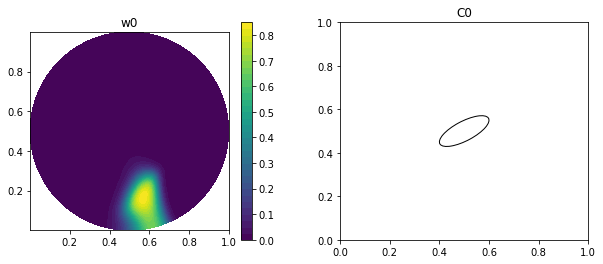

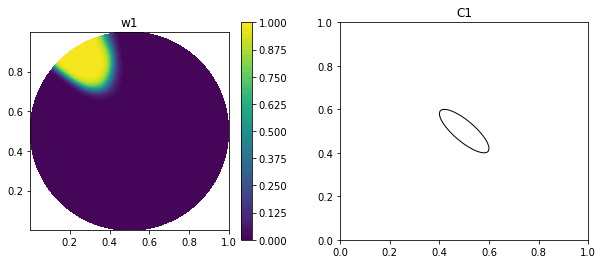

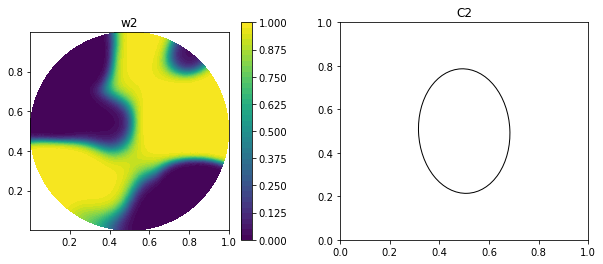

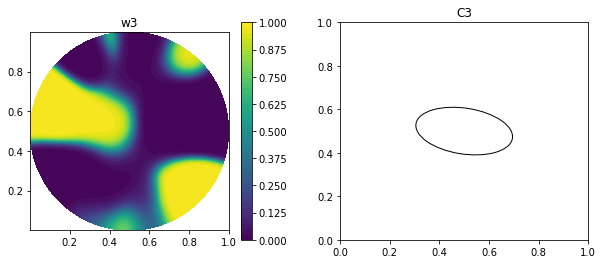

In [61]:
nw = len(ww)
for k in range(nw):
    f = plt.figure()
    f.set_figwidth(10)
    
    plt.subplot(1,2,1)
    c = fenics.plot(ww[k])
    plt.colorbar(c)
    plt.title('w'+str(k))
    
    ax = plt.subplot(1,2,2)
    plot_ellipse(ax, np.array([0.5,0.5]), CC[k], 1.0)
    plt.title('C'+str(k))
    ax.set_xlim(0.0, 1.0)
    ax.set_ylim(0.0, 1.0)
    plt.subplots_adjust(wspace=0.25)

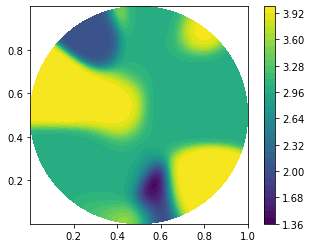

In [62]:
# cc = 10*np.random.rand(len(ww))
cc = np.arange(len(ww))+1.

w_sum = fenics.Function(V)
for w, c in zip(ww, cc):
    w_sum.vector()[:] = w_sum.vector()[:] + c * w.vector()
# w_sum.vector()[:] = (cc[0] * ww[0].vector() +
#                      cc[1] * ww[1].vector() +
#                      5.0 * ww[2].vector() +
#                      3.0 * ww[3].vector())

cm = fenics.plot(w_sum)
plt.colorbar(cm)

$$u_t = -\nabla \cdot \kappa \nabla u$$
Input at $u(0)$
Observations at $t=T$

In [64]:
kappa = interpolate_matrices(ww, CC)

Text(0.5, 1.0, 'kappa')

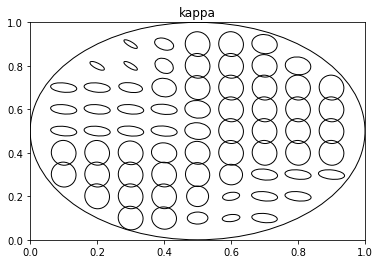

In [65]:
fig = plt.figure()
ax = fig.add_subplot(111)
plot_ellipse(ax, mesh_center, np.eye(2), mesh_radius)

xx = np.linspace(0., 1., 11)
yy = np.linspace(0., 1., 11)

for ii in range(len(xx)):
    for jj in range(len(yy)):
        mu = np.array([xx[ii], yy[jj]])
        if np.linalg.norm(mu - mesh_center) < mesh_radius:
            Sigma = kappa(np.array(mu)).reshape((2,2))
            plot_ellipse(ax, mu, Sigma, 0.20)
            
plt.title('kappa')

In [35]:
u_trial = fenics.TrialFunction(V)
v_test = fenics.TestFunction(V)

mass_form = u_trial * v_test * fenics.dx
M = fenics.assemble(mass_form)
solve_M = make_fenics_amg_solver(M)

stiffness_form = fenics.inner(kp * fenics.grad(u_trial), fenics.grad(v_test)) * fenics.dx
# stiffness_form = fenics.inner(kappa * fenics.grad(u_trial), fenics.grad(v_test)) * fenics.dx
A = fenics.assemble(stiffness_form)

In [36]:
delta_t = final_time_T / num_timesteps
Z_minus = M
Z_plus = M + delta_t * A

solve_Z_plus = make_fenics_amg_solver(Z_plus)

Text(0.5, 1.0, 'u0_true')

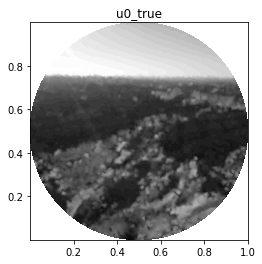

In [37]:
# zz = random_smooth_partition_of_unity(100, V, temperature=10, normalize=True)
# # zz = random_smooth_partition_of_unity(25, V, temperature=10, normalize=True)
#
# u0_true = fenics.Function(V)
# for k in range(len(zz)):
#     u0_true.vector()[:] = u0_true.vector() + (k**2) * zz[k].vector()

u0_true = load_angel_peak_badlands_image_into_fenics(V)
plt.figure()

fenics.plot(u0_true, cmap='gray')
plt.title('u0_true')

In [38]:
def forward_map(u0_petsc):
    uT_petsc = fenics.Vector(u0_petsc)
    for k in range(num_timesteps):
        uT_petsc = solve_Z_plus(Z_minus * uT_petsc)
    return uT_petsc

Text(0.5, 1.0, 'uT_true')

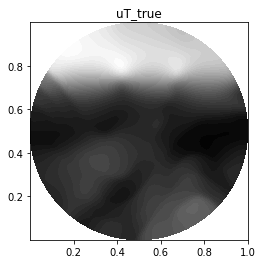

In [39]:
uT_true = fenics.Function(V)
uT_true.vector()[:] = forward_map(u0_true.vector())
fenics.plot(uT_true, cmap='gray')
plt.title('uT_true')

In [40]:
def adjoint_map(vT_petsc):
    v0_petsc = fenics.Vector(vT_petsc)
    for k in range(num_timesteps):
        v0_petsc = Z_minus * solve_Z_plus(v0_petsc)
    return v0_petsc

Perform adjoint correctness check

In [41]:
x = randn_fenics_function(V)
y = randn_fenics_function(V)
adjoint_err = np.abs(forward_map(x.vector()).inner(y.vector())
                     - x.vector().inner(adjoint_map(y.vector())))
print('adjoint_err=', adjoint_err)

adjoint_err= 4.27964608196163e-10


true_noise_level= 0.005000738730741155


Text(0.5, 1.0, 'uT_obs')

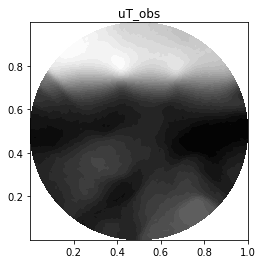

In [42]:
N = V.dim() 
normalized_noise = np.random.randn(N) / np.sqrt(N)
uT_obs = fenics.Function(V)
uT_obs.vector()[:] = uT_true.vector()[:] + noise_level * normalized_noise * np.linalg.norm(uT_true.vector()[:])

true_noise_level = fenics.norm(uT_obs.vector() - uT_true.vector())/fenics.norm(uT_true.vector())
print('true_noise_level=', true_noise_level)
fenics.plot(uT_obs, cmap='gray')
plt.title('uT_obs')

In [43]:
def objective(u0_petsc):
    uT_petsc = forward_map(u0_petsc)
    discrepancy = uT_petsc - uT_obs.vector()
    J = 0.5 * discrepancy.inner(M * discrepancy)
    return J

In [44]:
objective(u0_true.vector())

1.5894423007237034e-06

In [45]:
def gradient(u0_petsc):
    uT_petsc = forward_map(u0_petsc)
    discrepancy = uT_petsc - uT_obs.vector()
    return adjoint_map(M * discrepancy)

In [46]:
def apply_hessian(p_petsc):
    return adjoint_map(M * forward_map(p_petsc))

apply_Hd = apply_hessian
apply_Hd_t = apply_hessian

## Finite difference check for gradient and Hessian

In [47]:
u0 = fenics.Function(V)
u0.vector()[:] = np.random.randn(V.dim())

J = objective(u0.vector())
g = gradient(u0.vector())

du = fenics.Function(V)
du.vector()[:] = np.random.randn(V.dim())

In [48]:
ss = np.logspace(-15, 0, 11)
grad_errs = np.zeros(len(ss))
for k in range(len(ss)):
    s = ss[k]
    u0_2_vector = u0.vector() + s * du.vector()

    J2 = objective(u0_2_vector)
    dJ_diff = (J2 - J) / s
    dJ = g.inner(du.vector())
    grad_err = np.abs(dJ - dJ_diff) / np.abs(dJ_diff)
    grad_errs[k] = grad_err

    print('s=', s, ', grad_err=', grad_err)

<ipython-input-48-6eb42b1ced79>:10: RuntimeWarning: divide by zero encountered in double_scalars
  grad_err = np.abs(dJ - dJ_diff) / np.abs(dJ_diff)


s= 1e-15 , grad_err= inf
s= 3.1622776601683796e-14 , grad_err= 0.14387400057128086
s= 1e-12 , grad_err= 0.002706711956579668
s= 3.1622776601683794e-11 , grad_err= 0.00024211822259338832
s= 1e-09 , grad_err= 3.0001413825967447e-06
s= 3.162277660168379e-08 , grad_err= 6.6728605519958e-10
s= 1e-06 , grad_err= 1.288716972893852e-06
s= 3.1622776601683795e-05 , grad_err= 4.126676830956438e-05
s= 0.001 , grad_err= 0.001306607907347566
s= 0.03162277660168379 , grad_err= 0.043040700599388575
s= 1.0 , grad_err= 4.27973665955437


hess_err= 2.6594542876741854e-10


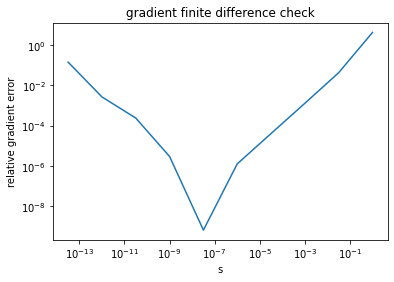

In [49]:
plt.figure()
plt.loglog(ss, grad_errs)
plt.title('gradient finite difference check')
plt.xlabel('s')
plt.ylabel('relative gradient error')

u0_2 = fenics.Function(V)
u0_2.vector()[:] = np.random.randn(V.dim())
dg = apply_hessian(u0_2.vector() - u0.vector())
g2 = gradient(u0_2.vector())
dg_diff = g2 - g
hess_err = fenics.norm(dg - dg_diff) / fenics.norm(dg_diff)
print('hess_err=', hess_err)

## Visualize Hessian impulse responses

$$g \mapsto M^{-1} H M^{-1} g$$

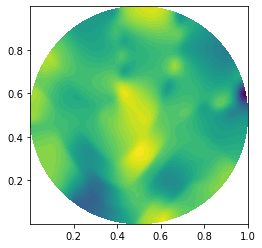

In [50]:
g = fenics.Function(V)
g.vector()[:] = np.random.randn(V.dim())

Hg = fenics.Function(V) 
Hg.vector()[:] = solve_M(apply_Hd(solve_M(g.vector())))

fenics.plot(Hg)

Text(0.5, 1.0, 'point source at [0.2 0.5]')

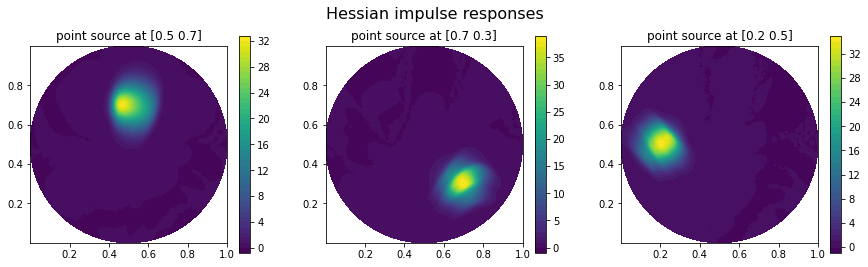

In [51]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))
fig.suptitle('Hessian impulse responses', fontsize=16)

plt.sca(axes[0])
pp = np.array([[0.5,0.7]])
Hdc = get_hessian_dirac_comb_response(pp, V, apply_Hd, solve_M)
cmap = fenics.plot(Hdc)
plt.colorbar(cmap)
plt.title('point source at '+str(pp[0,:]))

plt.sca(axes[1])
pp = np.array([[0.7,0.3]])
Hdc = get_hessian_dirac_comb_response(pp, V, apply_Hd, solve_M)
cmap = fenics.plot(Hdc)
plt.colorbar(cmap)
plt.title('point source at '+str(pp[0,:]))

plt.sca(axes[2])
pp = np.array([[0.2,0.5]])
Hdc = get_hessian_dirac_comb_response(pp, V, apply_Hd, solve_M)
cmap = fenics.plot(Hdc)
plt.colorbar(cmap)
plt.title('point source at '+str(pp[0,:]))

making mass matrix and solver
getting spatially varying volume
getting spatially varying mean
getting spatially varying covariance
constructing fast evaluators
done
getting nodes on boundary
done
computing inds of points far from boundary
done


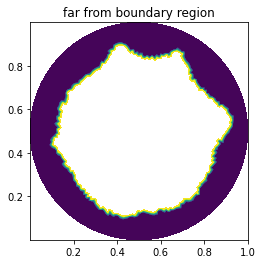

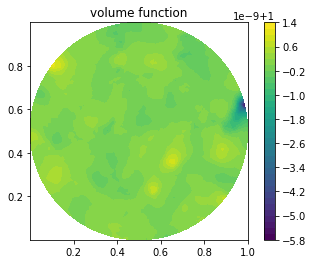

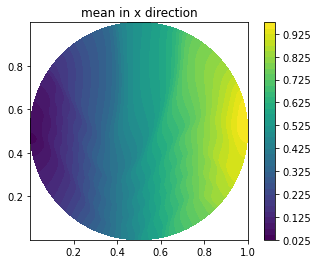

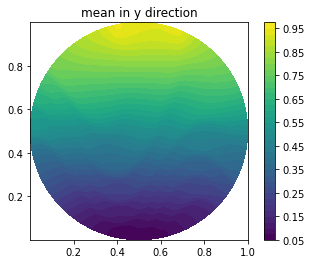

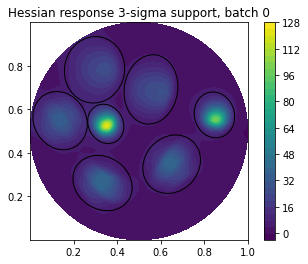

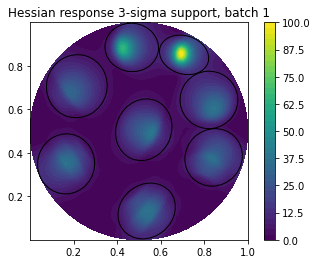

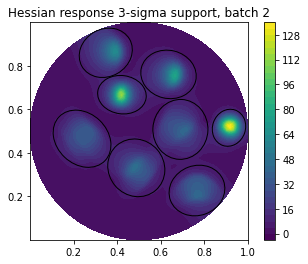

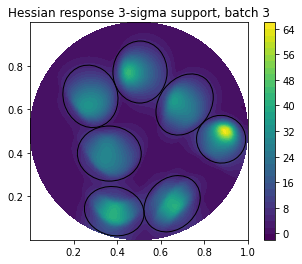

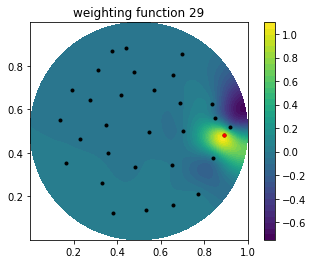

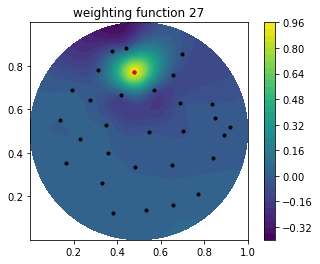

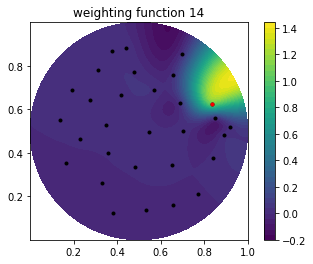

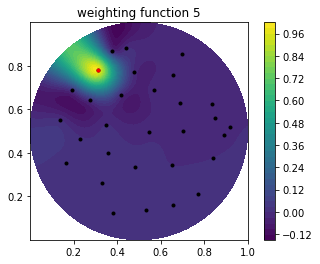

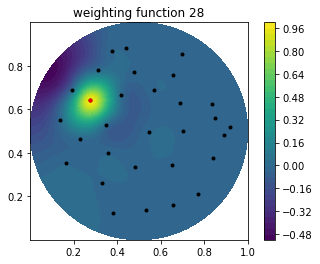

In [53]:
lpsf = LocalPSF(apply_Hd, apply_Hd_t, V, max_batches=5, num_standard_deviations_tau=2.5)

lpsf.make_plots()

In [54]:
N = 123456
pp = mesh_center.reshape((1,-1)) + np.random.randn(N, 2)
qq = mesh_center.reshape((1,-1)) + np.random.randn(N, 2)

t = time()
zz_cpp = lpsf.evaluate_approximate_hessian_entries_at_points_yy_xx(pp, qq)
dt_cpp = time() - t
print('dt_cpp=', dt_cpp)

t = time()
zz_py = lpsf.old_evaluate_approximate_hessian_entries_at_points_yy_xx(pp, qq)
dt_py = time() - t
print('dt_py=', dt_py)

bpc_cpp_err = np.linalg.norm(zz_cpp - zz_py) / np.linalg.norm(zz_py)
print('bpc_cpp_err=', bpc_cpp_err)

dt_cpp= 2.092902898788452
dt_py= 0.24499893188476562
bpc_cpp_err= 0.0


err_Phi2= 0.5023795167967479


Text(0.5, 1.0, 'Phi_true')

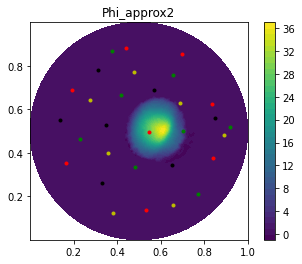

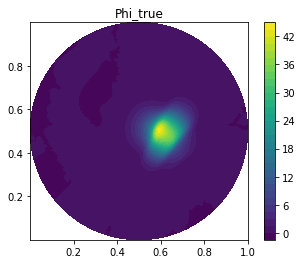

In [55]:
pp = X
q0 = np.array([[0.60,0.50]])
qq = np.dot(np.ones((X.shape[0],1)), q0)

Phi_true = get_hessian_dirac_comb_response(q0, V, apply_Hd, solve_M)

Phi_approx2 = fenics.Function(V)
Phi_approx2.vector()[:] = lpsf.evaluate_approximate_hessian_entries_at_points_yy_xx(X, qq)

err_Phi2 = fenics.norm(Phi_approx2.vector() - Phi_true.vector())/fenics.norm(Phi_true.vector())
print('err_Phi2=', err_Phi2)

plt.figure()
cm = fenics.plot(Phi_approx2)
plt.colorbar(cm)
plt.title('Phi_approx2')

# for x in lpsf.PSI.points:
#     plt.plot(x[0], x[1], '.r')
pp = lpsf.point_batches[0]
for k in range(pp.shape[0]):
    plt.plot(pp[k,0], pp[k,1], '.k')
    
pp = lpsf.point_batches[1]
for k in range(pp.shape[0]):
    plt.plot(pp[k,0], pp[k,1], '.r')
    
pp = lpsf.point_batches[2]
for k in range(pp.shape[0]):
    plt.plot(pp[k,0], pp[k,1], '.g')
    
pp = lpsf.point_batches[3]
for k in range(pp.shape[0]):
    plt.plot(pp[k,0], pp[k,1], '.y')

plt.figure()
cm = fenics.plot(Phi_true)
plt.colorbar(cm)
plt.title('Phi_true')

In [ ]:
ct = hpro.build_cluster_tree_from_dof_coords(X, 60)
hpro.visualize_cluster_tree(ct, "heat_inverse_problem_cluster_tree")

bct = hpro.build_block_cluster_tree(ct, ct, 2.0)
hpro.visualize_block_cluster_tree(bct, "heat_inverse_problem_block_cluster_tree")

Hd_hmatrix = lpsf.build_hmatrix(bct, tol=1e-8, symmetrize=True)

hpro.visualize_hmatrix(Hd_hmatrix, "heat_inverse_problem_hmatrix")

In [33]:
Hd_hmatrix_T = Hd_hmatrix.T

z1 = np.random.randn(Hd_hmatrix.shape[1])
z2 = np.random.randn(Hd_hmatrix_T.shape[1])

err_transpose = np.dot(z2, Hd_hmatrix.matvec(z1)) - np.dot(Hd_hmatrix_T.matvec(z2), z1)
print('err_transpose=', err_transpose)

q1 = Hd_hmatrix.matvec(z1)
q2 = Hd_hmatrix_T.matvec(z1)

nonsymmetry = np.linalg.norm(q1-q2)/np.linalg.norm(q1)
print('nonsymmetry=', nonsymmetry)

Hd_hmatrix_sym = Hd_hmatrix.sym(rtol=1e-10)

err_symmetrize = np.dot(z2, Hd_hmatrix_sym.matvec(z1)) - np.dot(Hd_hmatrix_sym.matvec(z2), z1)
print('err_symmetrize=', err_symmetrize)


err_transpose= 1.0842021724855044e-19
nonsymmetry= 2.2837968509537294e-08
err_symmetrize= 4.228388472693467e-18


err_hmatvec= 0.2346678179337705


Text(0.5, 1.0, 'error (difference)')

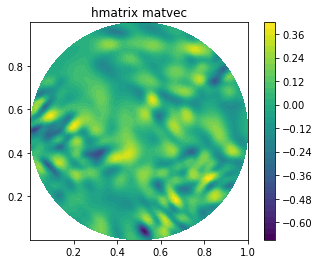

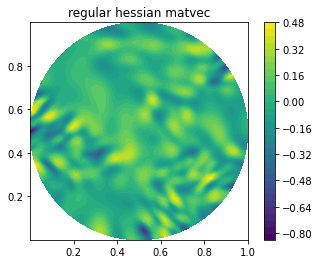

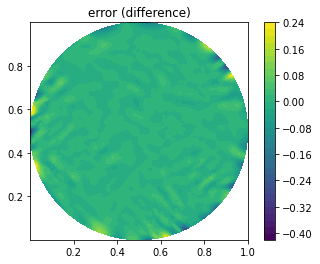

In [34]:
z = fenics.Function(V)
z.vector()[:] = np.random.randn(X.shape[0])

v = fenics.Function(V)
# v.vector()[:] = hpro.hmatrix_matvec(A_hmatrix, ct, ct, (M * z.vector())[:])
v.vector()[:] = Hd_hmatrix * z.vector()[:]
v.vector()[:] = solve_M(v.vector())

v2 = fenics.Function(V)
v2.vector()[:] = solve_M(apply_Hd(z.vector()))

err_hmatvec = np.linalg.norm(v.vector()[:] - v2.vector()[:])/np.linalg.norm(v2.vector()[:])
print('err_hmatvec=', err_hmatvec)

cm1 = fenics.plot(v)
plt.colorbar(cm1)
plt.title('hmatrix matvec')

plt.figure()
cm2 = fenics.plot(v2)
plt.colorbar(cm2)
plt.title('regular hessian matvec')

plt.figure()
cm3 = fenics.plot(v2 - v)
plt.colorbar(cm3)
plt.title('error (difference)')

In [35]:
def convert_fenics_csr_matrix_to_scipy_csr_matrix(A_fenics):
    ai, aj, av = fenics.as_backend_type(A_fenics).mat().getValuesCSR()
    A_scipy = sps.csr_matrix((av, aj, ai))
    return A_scipy

In [36]:
u_trial = fenics.TrialFunction(V)
v_test = fenics.TestFunction(V)
k_form = fenics.inner(fenics.grad(u_trial), fenics.grad(v_test))*fenics.dx
K = fenics.assemble(k_form)

K_csc = convert_fenics_csr_matrix_to_scipy_csr_matrix(K)
M_csc = convert_fenics_csr_matrix_to_scipy_csr_matrix(M)

R_csc = K_csc + 1e0*M_csc

In [37]:
M_hmatrix = hpro.build_hmatrix_from_scipy_sparse_matrix(M_csc, bct)
R_hmatrix = hpro.build_hmatrix_from_scipy_sparse_matrix(R_csc, bct)

hpro.visualize_hmatrix(M_hmatrix, "heat_inverse_problem_R_hmatrix")

In [38]:
x = np.random.randn(V.dim())
y1 = R_csc * x
y2 = R_hmatrix * x
err_R_hmatrix = np.linalg.norm(y2-y1)/np.linalg.norm(y1)
print('err_R_hmatrix=', err_R_hmatrix)

err_R_hmatrix= 1.2450994142775653e-16


In [39]:
x = np.random.randn(V.dim())
y1 = M_csc * x
y2 = M_hmatrix * x
err_M_hmatrix = np.linalg.norm(y2-y1)/np.linalg.norm(y1)
print('err_M_hmatrix=', err_M_hmatrix)

err_M_hmatrix= 1.2863955765651482e-16


In [40]:
def apply_H(x_vec):
    x = fenics.Function(V)
    x.vector()[:] = x_vec
    y_vec = apply_Hd(x.vector())[:] + a_reg*(R_csc*x_vec)
    return y_vec

H_linop = spla.LinearOperator((V.dim(), V.dim()), matvec=apply_H)

In [41]:
R_scale_err = np.linalg.norm((a_reg * R_hmatrix) * x - a_reg * R_csc * x)
print('R_scale_err=', R_scale_err)

R_scale_err= 3.6329006566869495e-18


In [42]:
H_hmatrix = Hd_hmatrix + a_reg * R_hmatrix

hpro.visualize_hmatrix(H_hmatrix, "heat_inverse_problem_H_hmatrix_sym")

In [43]:
x = np.random.randn(V.dim())
y1 = H_hmatrix * x
y2 = Hd_hmatrix * x + a_reg * (R_csc * x)
np.linalg.norm(y2-y1)/np.linalg.norm(y2)

6.807808878967434e-16

In [44]:
iH_hmatrix = H_hmatrix.factorized_inverse()

In [45]:
err_H_matrix_factorization = np.linalg.norm(x - H_hmatrix * iH_hmatrix.matvec(x))/np.linalg.norm(x)
print('err_H_matrix_factorization=', err_H_matrix_factorization)

err_H_matrix_factorization= 3.090680047953399e-09


In [46]:
krylov_iter=20
krylov_tol=1e-12

# Hfull_linop = spla.LinearOperator((V.dim(), V.dim()), matvec=apply_H)

solve_R = spla.factorized(a_reg * R_csc)
solve_R_linop = spla.LinearOperator((V.dim(), V.dim()), matvec=solve_R)

b = np.random.randn(V.dim())
# x_true = np.linalg.solve(H_true, b)

x_R = spla.gmres(H_linop, b, M=solve_R_linop, restart=krylov_iter, maxiter=1, tol=krylov_tol)[0]
err_reg = np.linalg.norm(apply_H(x_R) - b)/np.linalg.norm(b)
print('err_reg=', err_reg)

x_pre = spla.gmres(H_linop, b, M=iH_hmatrix, restart=krylov_iter, maxiter=1, tol=krylov_tol)[0]
err_pre = np.linalg.norm(apply_H(x_pre) - b)/np.linalg.norm(b)
print('err_pre=', err_pre)

/home/nick/anaconda3/envs/fenics2/lib/python3.8/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)


err_reg= 0.12639594170230137
err_pre= 1.4003714495987289e-11


Text(0.5, 1.0, '-gradient at zero')

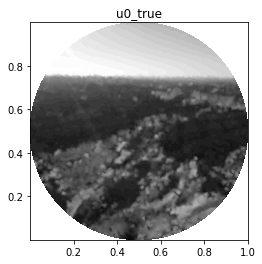

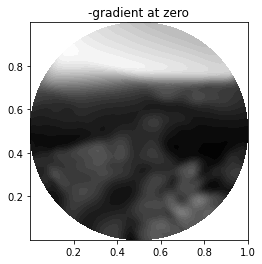

In [47]:
z0 = fenics.Function(V)

g_dual = gradient(z0.vector())
g = g_dual[:]
g_reisz = fenics.Function(V)
g_reisz.vector()[:] = solve_M(g_dual)

fenics.plot(u0_true, cmap='gray')
plt.title('u0_true')

plt.figure()
fenics.plot(-g_reisz, cmap='gray')
plt.title('-gradient at zero')

u0_err_exact= 1.2111576853895457e-10


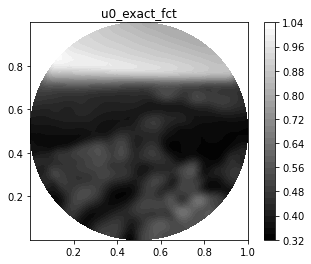

In [48]:
u0_exact = spla.gmres(H_linop, -g, M=iH_hmatrix, restart=50, maxiter=1, tol=krylov_tol)[0]
u0_err_exact = np.linalg.norm(apply_H(u0_exact) + g)/np.linalg.norm(g)
print('u0_err_exact=', u0_err_exact)

u0_exact_fct = fenics.Function(V)
u0_exact_fct.vector()[:] = u0_exact
cm = fenics.plot(u0_exact_fct, cmap='gray')
plt.colorbar(cm)
plt.title('u0_exact_fct')

uf_fct = fenics.Function(V)
uf_fct.vector()[:] = forward_map(u0_exact_fct.vector())

uf_true_fct = fenics.Function(V)
uf_true_fct.vector()[:] = forward_map(u0_true.vector())

In [49]:
morozov_discrepancy = np.sqrt(fenics.assemble((uf_true_fct - uf_fct)**2 * fenics.dx))

obs_norm = np.sqrt(fenics.assemble(uf_true_fct**2 * fenics.dx))

morozov_relative_noise_level = morozov_discrepancy / obs_norm
# morozov_discrepancy = np.sqrt(2.0 * objective(u0_exact_fct.vector()))

# fenics.assemble(uf_true_fct * fenics.dx)
#
# morozov_discrepancy2 = np.linalg.norm(uf_true[:] - uf[:])/np.linalg.norm(uf_true[:])

print('morozov_discrepancy=', morozov_discrepancy, ', obs_norm=', obs_norm)
print('morozov_relative_noise_level=', morozov_relative_noise_level)

morozov_discrepancy= 0.010748715696179455 , obs_norm= 0.5025090434198796
morozov_relative_noise_level= 0.02139009404294082


u0_err_none= 0.028796634888207075
u0_err_reg= 0.059665661756556465
u0_err_pre= 0.00013403572579099036


Text(0.5, 1.0, 'u0_pre_fct')

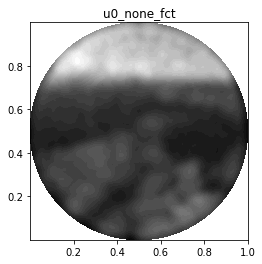

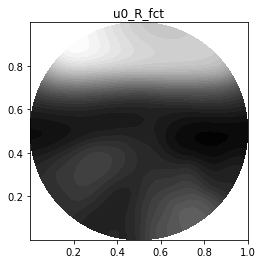

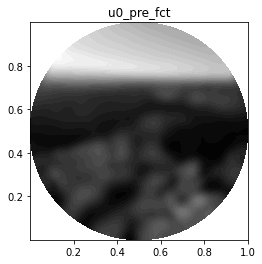

In [50]:
krylov_iter=5
krylov_tol=1e-12

u0_none = spla.gmres(H_linop, -g, restart=krylov_iter, maxiter=1, tol=krylov_tol)[0]
u0_err_none = np.linalg.norm(apply_H(u0_none) + g)/np.linalg.norm(g)
print('u0_err_none=', u0_err_none)

u0_R = spla.gmres(H_linop, -g, M=solve_R_linop, restart=krylov_iter, maxiter=1, tol=krylov_tol)[0]
u0_err_reg = np.linalg.norm(apply_H(u0_R) + g)/np.linalg.norm(g)
print('u0_err_reg=', u0_err_reg)

u0_pre = spla.gmres(H_linop, -g, M=iH_hmatrix, restart=krylov_iter, maxiter=1, tol=krylov_tol)[0]
u0_err_pre = np.linalg.norm(apply_H(u0_pre) + g)/np.linalg.norm(g)
print('u0_err_pre=', u0_err_pre)

plt.figure()
u0_none_fct = fenics.Function(V)
u0_none_fct.vector()[:] = u0_none
fenics.plot(u0_none_fct, cmap='gray')
plt.title('u0_none_fct')

plt.figure()
u0_R_fct = fenics.Function(V)
u0_R_fct.vector()[:] = u0_R
fenics.plot(u0_R_fct, cmap='gray')
plt.title('u0_R_fct')

plt.figure()
u0_pre_fct = fenics.Function(V)
u0_pre_fct.vector()[:] = u0_pre
fenics.plot(u0_pre_fct, cmap='gray')
plt.title('u0_pre_fct')

In [ ]:
Z_linop = spla.LinearOperator(H_linop.shape, matvec=lambda x:H_linop.matvec(x) - H_hmatrix_sym.matvec(x))
#
# dd, P = spla.eigsh(Z_linop, k=6, M=H_hmatrix_sym, Minv=H_hmatrix_sym_factorized, mode='buckling', which='LM')

A_linop = spla.LinearOperator(Z_linop.shape,
                              matvec=lambda x:H_hmatrix_sym_factorized.matvec(H_linop.matvec(x))-x,
                              rmatvec=lambda x: H_linop.matvec(H_hmatrix_sym_factorized.matvec(x))-x)

AR_linop = spla.LinearOperator(Z_linop.shape,
                              matvec=lambda x:solve_R_linop.matvec(H_linop.matvec(x))-x,
                              rmatvec=lambda x: H_linop.matvec(solve_R_linop.matvec(x))-x)

# _,ss,_ = spla.svds(Q_linop, k=6, which='LM')

_,ss,_ = basic_randomized_svd(A_linop, 500)
_,ssR,_ = basic_randomized_svd(AR_linop, 500)

In [ ]:
plt.figure()
plt.semilogy(ss)
plt.semilogy(ssR)
plt.legend(['ss', 'ssR'])
plt.title('preconditioned singular values')

In [ ]:
ss

In [ ]:
Happrox_dense = np.zeros((V.dim(), V.dim()))
for k in range(V.dim()):
#     print('k=', k)
    ek = np.zeros(V.dim())
    ek[k] = 1.0
    Happrox_dense[k,:] = Hfull_hmatrix * ek

In [ ]:
plt.matshow(Happrox_dense)

In [ ]:
H_dense = np.zeros((V.dim(), V.dim()))
for k in range(V.dim()):
    print('k=', k)
    ek = np.zeros(V.dim())
    ek[k] = 1.0
    H_dense[k,:] = apply_Hfull(ek)

In [ ]:
np.linalg.norm(Happrox_dense - H_dense)/np.linalg.norm(H_dense)

In [ ]:
invH_hmatrix = hpro.convert_sparse_csc_matrix_to_hmatrix(a_reg*R_csc, ct, ct, bct)
hpro.hmatrix_add_overwrites_second(A_hmatrix, invH_hmatrix, 1e-6)
hpro.hmatrix_factorized_inverse_destructive(invH_hmatrix, 1e-6)

def apply_invH_approx(x_vec):
    x = fenics.Function(V)
    x.vector()[:] = x_vec

    iHMx = fenics.Function(V)
    iHMx.vector()[:] = hpro.hmatrix_matvec(invH_hmatrix, ct, ct, (M * x.vector())[:])
    return (M * iHMx.vector())[:]

apply_invH_approx_linop = spla.LinearOperator((V.dim(), V.dim()), matvec=apply_invH_approx)

In [ ]:
iH_dense = np.zeros((V.dim(), V.dim()))
for k in range(V.dim()):
#     print('k=', k)
    ek = np.zeros(V.dim())
    ek[k] = 1.0
    iH_dense[k,:] = apply_invH_approx(ek)

In [ ]:
plt.matshow(H_dense - a_reg*R_csc.toarray())

In [ ]:
_,ss,_ = np.linalg.svd(G)
ss
plt.semilogy(ss)

In [ ]:

# x2 = hpro.hmatrix_factorized_inverse_matvec(inv_A, ct, ct, y)

In [ ]:
ek = fenics.Function(V).vector()
A_true = np.zeros((V.dim(), V.dim()))
for k in range(V.dim()):
    ek[:] = 0.
    ek[k] = 1.
    A_true[:,k] = apply_H(ek)[:]

In [ ]:
plt.matshow(A_true)

In [ ]:
iM_A_iM = np.zeros((V.dim(), V.dim()))
for k in range(V.dim()):
    q0 = X[k,:].reshape((1,-1))
    qq = np.dot(np.ones((V.dim(),1)), q0)
    iM_A_iM[k,:] = lpsf.evaluate_approximate_hessian_entries_at_points_yy_xx(X, qq)[:]
    

In [ ]:
M_numpy = M.array()
A_approx = np.dot(M_numpy, np.dot(iM_A_iM, M_numpy))
# A_approx = np.dot(M_numpy, iM_A_iM)

In [ ]:
plt.matshow(A_approx)

In [ ]:
np.linalg.norm(A_approx - A_true)/np.linalg.norm(A_true)

In [ ]:
u_trial = fenics.TrialFunction(V)
v_test = fenics.TestFunction(V)
k_form = fenics.inner(fenics.grad(u_trial), fenics.grad(v_test))*fenics.dx
K = fenics.assemble(k_form)
K_numpy = K.array()

Reg = K_numpy + 1e0*M_numpy

_,ssM,_ = np.linalg.svd(M_numpy)
_,ssK,_ = np.linalg.svd(K_numpy)
_,ssR,_ = np.linalg.svd(Reg)

plt.semilogy(ssM)
plt.semilogy(ssK)
plt.semilogy(ssR)
plt.legend(['M', 'K', 'R'])

In [ ]:
a_reg = 2e-5
H_true = A_true + a_reg * Reg
H_true = (H_true + H_true.T)/2.
H_approx0 = A_approx + a_reg * Reg
H_approx = (H_approx0 + H_approx0.T)/2.

In [ ]:
U,ss_true,_ = np.linalg.svd(A_true)
ss_approx = np.abs(np.diagonal(np.dot(U.T,np.dot(A_approx,U))))
ss_reg = np.diagonal(np.dot(U.T,np.dot(Reg,U)))

In [ ]:
plt.semilogy(ss_true[:500])
plt.semilogy(ss_approx[:500])
plt.semilogy(a_reg*ss_reg[:500])
plt.legend(['A_true', 'A_approx', 'Reg'])
plt.xlabel('i')
plt.ylabel('lambda_i')

In [ ]:
H_pre = np.linalg.solve(H_approx, H_true)
_,ss_pre,_ = np.linalg.svd(H_pre)

H_preR = np.linalg.solve(a_reg * Reg, H_true)
_,ss_preR,_ = np.linalg.svd(H_preR)

In [ ]:
plt.figure()
plt.semilogy(ss_pre)
plt.semilogy(ss_preR)
plt.legend(['H_pre', 'H_preR'])
plt.xlabel('i')
plt.ylabel('lambda_i')

cond_pre = np.max(ss_pre)/np.min(ss_pre)
cond_preR = np.max(ss_preR)/np.min(ss_preR)

print('cond_pre=', cond_pre)
print('cond_preR=', cond_preR)

## Random RHS

In [ ]:
krylov_iter=20
krylov_tol=1e-12

b = np.random.randn(V.dim())
x_true = np.linalg.solve(H_true, b)

x_R = spla.gmres(H_true, b, M=np.linalg.inv(Reg), restart=krylov_iter, maxiter=1, tol=krylov_tol)[0]
err_reg = np.linalg.norm(x_true - x_R)/np.linalg.norm(x_true)
print('err_reg=', err_reg)

x_pre = spla.gmres(H_true, b, M=np.linalg.inv(H_approx), restart=krylov_iter, maxiter=1, tol=krylov_tol)[0]
err_pre = np.linalg.norm(x_true - x_pre)/np.linalg.norm(x_true)
print('err_pre=', err_pre)

## Gradient RHS

### Try deflating spectrum

In [ ]:
H_pre2 = np.linalg.solve(H_approx, H_true)
U,ss,Vt = np.linalg.svd(H_pre2 - np.eye(V.dim()))

In [ ]:
r2 = 5
plt.semilogy(ss)
np.sum(ss > r2)

In [ ]:
P = H_approx2
delta_P = np.dot(P, np.dot(U[:,:r2], np.dot(np.diag(ss[:r2]), Vt[:r2,:])))
P2 = P + delta_P
H_pre3 = np.linalg.solve(P2, H_true)

In [ ]:
_,ll0,_ = np.linalg.svd(H_true)
_,ll1,_ = np.linalg.svd(P)
_,ll2,_ = np.linalg.svd(P2)

plt.semilogy(ll0)
plt.semilogy(ll1)
plt.semilogy(ll2)

In [ ]:
e0 = np.linalg.norm(P - H_true)/np.linalg.norm(H_true)
e1 = np.linalg.norm(P2 - H_true)/np.linalg.norm(H_true)
print('e0=', e0)
print('e1=', e1)

In [ ]:
import scipy.sparse.linalg as spla

# b_form = fenics.Expression('sin(5*x[0])*cos(3*x[1]) + x[0]*x[1]', degree=1)*fenics.TestFunction(V)*fenics.dx
# b = fenics.assemble(b_form)[:]
# b = np.random.randn(V.dim())
b = np.dot(H_true, ww[1].vector()[:])
b_fct = fenics.Function(V)
b_fct.vector()[:] = np.linalg.solve(M_numpy, b)
x_true = np.linalg.solve(H_true, b)

x_approx = np.linalg.solve(H_approx2, b)
x_approx3 = np.linalg.solve(P2, b)

err_approx = np.linalg.norm(x_true - x_approx)/np.linalg.norm(x_true)
print('err_approx=', err_approx)

err_approx3 = np.linalg.norm(x_true - x_approx3)/np.linalg.norm(x_true)
print('err_approx3=', err_approx3)

x_true_fct = fenics.Function(V)
x_true_fct.vector()[:] = x_true

x_approx_fct = fenics.Function(V)
x_approx_fct.vector()[:] = x_approx

x_approx3_fct = fenics.Function(V)
x_approx3_fct.vector()[:] = x_approx3

fenics.plot(x_true_fct)
plt.figure()
fenics.plot(x_approx_fct)
plt.figure()
fenics.plot(x_approx3_fct)

In [ ]:
fenics.plot(b_fct)

In [ ]:
iter = 20
krylov_tol = 1e-12

x0 = spla.gmres(H_true, b, restart=iter, maxiter=1, tol=krylov_tol)[0]
# x0 = spla.gmres(H_true, b, maxiter=iter)[0]
err0 = np.linalg.norm(x_true - x0)/np.linalg.norm(x_true)
# err0 = np.linalg.norm(np.dot(H_true,x0) - b)/np.linalg.norm(b)
print('err0=', err0)

x1 = spla.gmres(H_true, b, M=np.linalg.inv(Reg), restart=iter, maxiter=1, tol=krylov_tol)[0]
# x1 = spla.gmres(H_true, b, M=np.linalg.inv(Reg), maxiter=iter)[0]
# x1 = spla.minres(H_true, b, M=Reg, maxiter=iter)[0]
# x1 = spla.gmres(H_true, b, M=Reg, maxiter=iter)[0]
err1 = np.linalg.norm(x_true - x1)/np.linalg.norm(x_true)
# np.linalg.norm(np.dot(H_true,x1) - b)/np.linalg.norm(b)
print('err1=', err1)

x2 = spla.gmres(H_true, b, M=np.linalg.inv((H_approx+H_approx.T)/2.), restart=iter, maxiter=1, tol=krylov_tol)[0]
# x2 = spla.gmres(H_true, b, M=np.linalg.inv((P2+P2.T)/2.), restart=iter, maxiter=1, tol=krylov_tol)[0]
# x2 = spla.minres(H_true, b, M=np.linalg.inv(H_approx2), maxiter=iter)[0]
# x2 = spla.gmres(H_true, b, M=np.linalg.inv(H_approx2), restart=iter, maxiter=1)[0]
# x2 = spla.minres(H_true, b, M=H_approx2, maxiter=iter)[0]
# x2 = spla.gmres(H_true, b, M=H_approx2, maxiter=iter)[0]
err2 = np.linalg.norm(x_true - x2)/np.linalg.norm(x_true)
# np.linalg.norm(np.dot(H_true,x2) - b)/np.linalg.norm(b)
print('err2=', err2)

x1_fct = fenics.Function(V)
x1_fct.vector()[:] = x1

fenics.plot(x1_fct)
plt.title('x1_fct')

plt.figure()
x2_fct = fenics.Function(V)
x2_fct.vector()[:] = x2

cm = fenics.plot(x2_fct)
plt.title('x2_fct')
plt.colorbar(cm)

plt.figure()
cm = fenics.plot(x_true_fct - x1_fct)
plt.colorbar(cm)
plt.title('err1 function')

plt.figure()
cm = fenics.plot(x_true_fct - x2_fct)
plt.colorbar(cm)
plt.title('err2 function')

In [ ]:
err0

In [ ]:
point_batches = list()
dirac_comb_responses = list()
dirac_comb_response_evaluators = list()
mu_batches = list()
Sigma_batches = list()
PSI = PoissonSquaredInterpolation(V)

def add_new_batch():
    new_inds = choose_sample_points_batch(cur_mu, cur_Sigma, num_std_dev_tau, np.array(candidate_inds))
    new_points = candidate_points[new_batch_inds, :]
    point_batches.append(new_points)
    candidate_inds = list(np.setdiff1d(candidate_inds, new_inds))

    mu_batches.append(eval_mu(new_points))
    all_Sigma_batches.append(eval_Sigma(new_points))
    
    new_dirac_comb_response = get_dirac_comb_response(new_batch_points)
    dirac_comb_responses.append(new_dirac_comb_response)
    dirac_comb_response_evaluators.append(FenicsFunctionFastGridEvaluator(new_dirac_comb_response))
    
    PSI.add_points([new_points[k,:] for k in range(new_points.shape[0])])
    

In [ ]:
PSI = PoissonSquaredInterpolation(V)

In [ ]:
latest_batch_inds = choose_sample_points_batch(cur_mu, cur_Sigma, num_std_dev_tau, np.array(candidate_inds))
latest_batch_of_points = candidate_points[latest_batch_inds, :]

latest_mu_batch = eval_mu(latest_batch_of_points)
all_mu_batches.append(latest_mu_batch)

latest_Sigma_batch = eval_Sigma(latest_batch_of_points)
all_Sigma_batches.append(latest_Sigma_batch)

In [ ]:
latest_eta = fenics.Function(V)
latest_eta.vector()[:] = get_dirac_comb_response(latest_batch_of_points)
all_eta.append(latest_eta)

latest_eval_eta = FenicsFunctionFastGridEvaluator(latest_eta)
all_eval_eta.append(latest_eval_eta)

In [ ]:
PSI.add_points([latest_batch_of_points[k,:] for k in range(latest_batch_of_points.shape[0])])

In [ ]:
for k in range(latest_batch_of_points.shape[0]):
    plt.figure()
    cmap = fenics.plot(PSI.weighting_functions[k])
    plt.plot(latest_batch_of_points[k,0], latest_batch_of_points[k,1],'.')
    plt.colorbar(cmap)

In [ ]:
all_eval_ww = [FenicsFunctionFastGridEvaluator(w) for w in PSI.weighting_functions]

In [ ]:
all_batches_of_points.append(latest_batch_of_points)
all_eta.append(latest_eta)
candidate_inds = list(np.setdiff1d(candidate_inds, latest_batch_inds))

me.BPC = BatchProductConvolution(me.all_eval_eta, me.all_eval_ww,
                                 me.all_batches_of_points, me.all_mu_batches, me.all_Sigma_batches, me.tau)